# Assessing the grade and quality of fruit

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/fruit.gif)

Fruits arrive in bulk at industries (like fruit juice or jam or any kind that uses fruit) and vary in quality from fresh to almost rotten. 

It is important to categorise them based on their quality so as to not affect the taste and quality of the final manufactured product.

For example, a rotten orange can spoil the taste of the entire juice batch. 

Here we have 1080 images of pomegranates divided into 12 categories based on grade and quality with 90 in each. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import os
import keras
import random
from PIL import Image

## Dataset

Fruits of 3 grades (G1, G2, G3) are collected. Once the pomegranate fruits are collected they are then imaged for every alternate day up to a duration of eight days, leading into four qualities (Q1, Q2, Q3, Q4) for each grade. Since, the process is recited for three grades, this resulted into a total of 12 classes of effective quality criteria, with four qualities within each grade.

The dataset folder has 12 subfolders, each corresponding to one of the 12 classes. Each of these subfolders has 90 images.


> Citation

> [1] Kumar R, A., Rajpurohit, V. S., & Bidari, K. Y. (2019). Multi Class Grading and Quality Assessment of Pomegranate Fruits Based on Physical and Visual Parameters. International Journal of Fruit Science, 19(4), 372-396.

> [2] Arun Kumar R, Vijay S. Rajpurohit, and Bhairu J. Jirage, "Pomegranate Fruit Quality Assessment Using Machine Intelligence and Wavelet Features," Journal of Horticultural Research, vol. 26, no. 1, pp. 53–60, 2018. doi: 10.2478/johr-2018-0006

In [3]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Pomegranate.zip
!unzip -qo Pomegranate.zip
!rm Pomegranate.zip

--2020-11-11 02:56:32--  https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/Pomegranate.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.116
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127534298 (122M) [application/x-zip-compressed]
Saving to: ‘Pomegranate.zip’

Pomegranate.zip     100%[===================>] 121.63M  67.7MB/s    in 1.8s    

2020-11-11 02:56:34 (67.7 MB/s) - ‘Pomegranate.zip’ saved [127534298/127534298]

Archive:  Pomegranate.zip
replace Pomegranate/G3_Q2/G3_Q2_13_2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
data_dir = 'Pomegranate'

print("Number of samples")
for f in os.listdir(data_dir + '/'):
    if os.path.isdir(data_dir + '/' + f):
        print(f, " : ", len(os.listdir(data_dir + '/' + f +'/')))

Number of samples
G1_Q3  :  90
G2_Q2  :  90
G3_Q1  :  90
G1_Q1  :  90
G3_Q3  :  90
G2_Q3  :  90
G1_Q4  :  90
G2_Q4  :  90
G1_Q2  :  90
G3_Q4  :  90
G2_Q1  :  90
G3_Q2  :  90


In [5]:
# Splitting into train and validation dataset  - 80-20 split.

batch_size = 16

print("Training set")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=113, batch_size=batch_size)  

print("Validation set")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=113, batch_size=batch_size)  

Training set
Found 1080 files belonging to 12 classes.
Using 864 files for training.
Validation set
Found 1080 files belonging to 12 classes.
Using 216 files for validation.


In [6]:
# Looking into the class names

class_names = train_ds.class_names
print(class_names)

['G1_Q1', 'G1_Q2', 'G1_Q3', 'G1_Q4', 'G2_Q1', 'G2_Q2', 'G2_Q3', 'G2_Q4', 'G3_Q1', 'G3_Q2', 'G3_Q3', 'G3_Q4']


## Visualisation

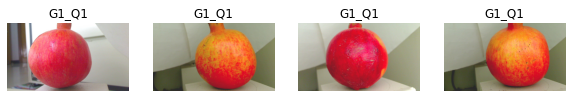

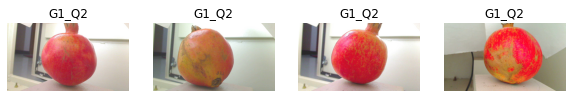

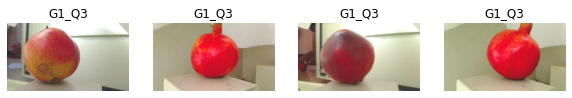

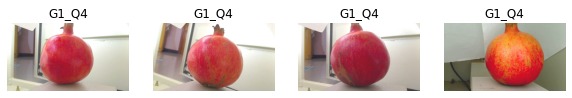

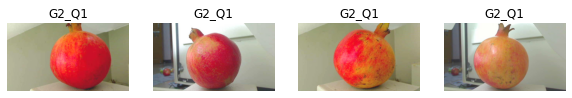

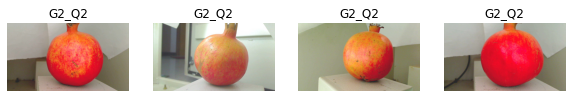

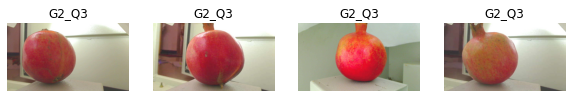

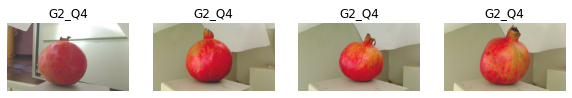

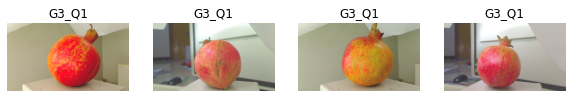

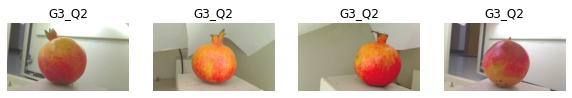

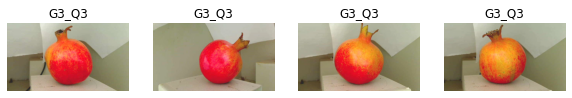

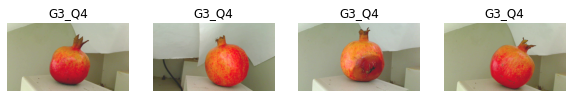

In [7]:
num_samples = 4    # the number of samples to be displayed in each class

for x in class_names:
    plt.figure(figsize=(10, 10))

    filenames = os.listdir(data_dir + '/' + x)

    for i in range(num_samples):
        j = i
        if filenames[i][-4:] =='xlsx':
            j = i+num_samples
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(data_dir +'/' + x + '/' + filenames[j])
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")

## Preprocessing

In [8]:
# Normalizing the pixel values - apply to both train and validation set

normalization_layer = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(1./255)
    ])


train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## Model architecture and training

In [23]:
# Using transfer learning
base_model = keras.applications.VGG16(weights='imagenet', input_shape=(256, 256, 3), include_top=False)    # False, do not include the classification layer of the model

base_model.trainable = False

inputs = tf.keras.Input(shape=(256, 256, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(len(class_names), activation = 'softmax')(x)    # Add own classififcation layer

model = keras.Model(inputs, outputs)

In [24]:
# training with a learning rate of 0.1
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

history1 = model.fit(train_ds, validation_data=val_ds, epochs=16)

Epoch 1/16
54/54 [==============================] - 549s 10s/step - loss: 5.1202 - accuracy: 0.1412 - val_loss: 2.7337 - val_accuracy: 0.2269
Epoch 2/16
54/54 [==============================] - 545s 10s/step - loss: 1.9856 - accuracy: 0.3657 - val_loss: 1.4834 - val_accuracy: 0.4769
Epoch 3/16
54/54 [==============================] - 543s 10s/step - loss: 1.6340 - accuracy: 0.4780 - val_loss: 1.8229 - val_accuracy: 0.4861
Epoch 4/16
54/54 [==============================] - 344s 6s/step - loss: 1.4815 - accuracy: 0.5382 - val_loss: 1.7619 - val_accuracy: 0.4306
Epoch 5/16
54/54 [==============================] - 356s 7s/step - loss: 1.2483 - accuracy: 0.6053 - val_loss: 1.3599 - val_accuracy: 0.5648
Epoch 6/16
54/54 [==============================] - 355s 7s/step - loss: 0.9077 - accuracy: 0.6840 - val_loss: 1.0448 - val_accuracy: 0.6343
Epoch 7/16
54/54 [==============================] - 354s 7s/step - loss: 0.8440 - accuracy: 0.7211 - val_loss: 1.7984 - val_accuracy: 0.5324
Epoch 8/16

In [25]:
# training with a learning rate of 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

history2 = model.fit(train_ds, validation_data=val_ds, epochs=16)

Epoch 1/16
54/54 [==============================] - 502s 9s/step - loss: 0.1913 - accuracy: 0.9537 - val_loss: 0.5944 - val_accuracy: 0.7731
Epoch 2/16
54/54 [==============================] - 340s 6s/step - loss: 0.1919 - accuracy: 0.9583 - val_loss: 0.6237 - val_accuracy: 0.7778
Epoch 3/16
54/54 [==============================] - 340s 6s/step - loss: 0.1894 - accuracy: 0.9537 - val_loss: 0.6028 - val_accuracy: 0.7917
Epoch 4/16
54/54 [==============================] - 342s 6s/step - loss: 0.1728 - accuracy: 0.9630 - val_loss: 0.5832 - val_accuracy: 0.7870
Epoch 5/16
54/54 [==============================] - 341s 6s/step - loss: 0.1654 - accuracy: 0.9676 - val_loss: 0.5375 - val_accuracy: 0.8009
Epoch 6/16
54/54 [==============================] - 350s 6s/step - loss: 0.1680 - accuracy: 0.9641 - val_loss: 0.5807 - val_accuracy: 0.7731
Epoch 7/16
54/54 [==============================] - 350s 6s/step - loss: 0.1440 - accuracy: 0.9769 - val_loss: 0.5173 - val_accuracy: 0.8102
Epoch 8/16
54

In [26]:
output = model.evaluate(val_ds)

14/14 [==============================] - 63s 5s/step - loss: 0.5089 - accuracy: 0.7963


## Plotting the metrics

In [27]:
def plot(history1, history2, variable1, variable2):
    # combining metrics from both trainings    
    var1_history = history1[variable1]
    var1_history.extend(history2[variable1])
    
    var2_history = history1[variable2]
    var2_history.extend(history2[variable2])
    
    # plotting them
    plt.plot(range(len(var1_history)), var1_history)
    plt.plot(range(len(var2_history)), var2_history)
    plt.legend([variable1, variable2])
    plt.title(variable1)

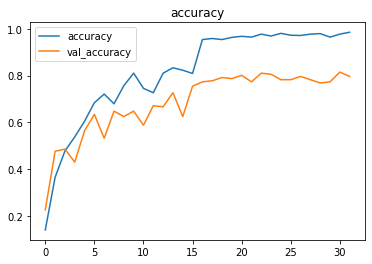

In [28]:
plot(history1.history, history2.history, "accuracy", 'val_accuracy')

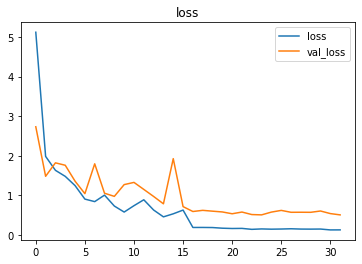

In [29]:
plot(history1.history, history2.history, "loss", 'val_loss')

## Prediction

In [9]:
model = tf.keras.models.load_model('pomegranate.h5')

Prdicted:  G2_Q2
True:  G2_Q2
Probability:  0.9773197


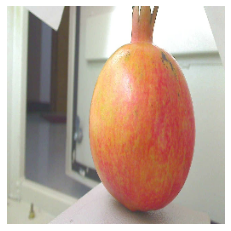

In [10]:
# pick random test data sample from one batch
x = random.randint(0, batch_size - 1)

for i in val_ds.as_numpy_iterator():
    img, label = i    
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (64, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = np.argmax(output[0])    # finding max
    print("Prdicted: ", class_names[pred])    # Picking the label from class_names base don the model output
    print("True: ", class_names[label[x]])
    print("Probability: ", output[0][pred])
    break

## deepC

In [31]:
model.save('pomegranate.h5')

!deepCC pomegranate.h5

reading [keras model] from 'pomegranate.h5'
Saved 'pomegranate.onnx'
reading onnx model from file  pomegranate.onnx
Model info:
  ir_vesion :  5 
  doc       : 
WARN (ONNX): graph-node block1_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block1_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_conv3's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block4_conv1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block4_conv2's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block4_conv3's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-

True:  G1_Q2
reading file sample.data.
Warn: vgg16_block1_conv2_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: vgg16_block2_conv2_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: vgg16_block3_conv3_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: vgg16_block4_conv3_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: vgg16_block5_conv3_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.


'\n# predict\noutput = np.loadtxt(\'dense_3.out\')\npred = np.argmax(output)    # finding max\nprint("Prdicted: ", class_names[pred])    # Picking the label from class_names base don the model output\nprint("True: ", class_names[label[x]])\nprint("Probability: ", output[pred])\n'

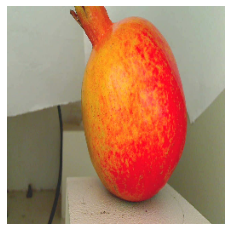

In [11]:
# pick random test data sample from one batch
x = random.randint(0, batch_size - 1)

for i in val_ds.as_numpy_iterator():
    img, label = i      # i contains all test samples
    np.savetxt('sample.data', (img[x]).flatten())    # xth sample into text file
    plt.axis('off')
    plt.imshow(img[x])
    print("True: ", class_names[label[x]])
    break
     
# run exe with input
!pomegranate_deepC/pomegranate.exe sample.data